In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.datasets import load_breast_cancer
from typing import List, Any

In [2]:
from numba import njit, prange
@njit(fastmath=True)
def gini_impurity(X: np.ndarray):
#     print([((y==c).sum()/len(y))**2 for c in np.unique(y)])
#     return 1 - np.sum([((X[:, -1]==c).sum()/X.shape[0])**2 for c in np.unique(X[:, -1])])
    result = 0
    classes = np.unique(X[:, -1])
    for c in classes:
        result += ((X[:, -1]==c).sum()/X.shape[0])**2
    return 1 - result

@njit(fastmath=True)
def gini_index(Xs: List[np.ndarray]):
#     total_size = np.sum(np.array([X.shape[0] for X in Xs]))
    total_size = 0
    for X in Xs:
        total_size += X.shape[0]
    if total_size == 0:
        return 1
    result = 0
    for X in Xs:
        result += X.shape[0]/total_size * gini_impurity(X)
    return result
#     return np.sum([X.shape[0]/total_size * gini_impurity(X) for X in Xs])

In [3]:
@njit
def split_data(X: np.ndarray, feature_index: int, split_value: float):
#     is_na = ~((X[:, feature_index] < split_value) | (X[:, feature_index] >= split_value))
    is_na = np.isnan(X[:, feature_index])
    left = X[(X[:, feature_index] < split_value) | is_na]
    right = X[(X[:, feature_index] >= split_value) | is_na]
    return left, right

In [4]:
@njit
def generate_split_points(X: np.ndarray, feature_index: int):
    splits = np.sort(X[:, feature_index])
    return set(splits[~np.isnan(splits)])

In [5]:
from dataclasses import dataclass
from typing import Union

@dataclass
class Leaf:
    value: int
    n_samples: int

@dataclass
class Tree:
    left: Union['Tree', Leaf]
    right: Union['Tree', Leaf]
    split_feature: int
    split_value: float
    n_samples: int

In [6]:
@njit(fastmath=True)
def get_split(X: np.ndarray):
    best_gini, best_feature, best_split, best_groups = np.inf, None, None, None
    for feature_index in range(X.shape[1]-1):
        for split_value in generate_split_points(X, feature_index):
            groups = split_data(X, feature_index, split_value)
            gini = gini_index(groups)
            if gini < best_gini:
                best_gini = gini
                best_feature = feature_index
                best_split = split_value
                best_groups = groups
    current_gini = gini_impurity(X)
    if current_gini < best_gini:
        return 0, 0, 0, (None, None)
    return best_feature, best_split, best_gini, best_groups

In [7]:
def most_frequent(a: np.ndarray):
    values, counts = np.unique(a, return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [8]:
def decision_tree(X: np.ndarray, last_gini=None):
    best_feature, best_split, best_gini, (left, right) = get_split(X)
#     print(best_gini)
#     print(left is None)
    if left is None or last_gini == best_gini:
        return Leaf(most_frequent(X[:, -1]), X.shape[0])
#     print(len(np.unique(left[:, -1])))
#     print(np.unique(left[:, -1]))
#     print(len(left))
    if len(np.unique(left[:, -1])) == 1:
#         print('left leaf')
        left_tree = Leaf(most_frequent(left[:, -1]), left.shape[0])
    elif len(np.unique(left[:, -1])) == 0:
#         print('left leaf')
        left_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
#         print('recurse')
        left_tree = decision_tree(left, last_gini=best_gini)
    
#     print(len(np.unique(right[:, -1])))
#     print(np.unique(right[:, -1]))
#     print(len(right))
#     print()
    if len(np.unique(right[:, -1])) == 1:
        right_tree = Leaf(most_frequent(right[:, -1]), right.shape[0])
    elif len(np.unique(right[:, -1])) == 0:
        right_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
#         print('right recurse')
#         print(best_split)
#         print(best_feature)
#         print(np.unique(right[best_feature]))
#         print(gini_index([left, right]))
#         print(gini_impurity(right))
        right_tree = decision_tree(right, last_gini=best_gini)
    
    return Tree(left_tree, right_tree, best_feature, best_split, X.shape[0])

In [9]:
t = decision_tree(np.concatenate([(X_train), y_train[:, None]], axis=1))

NameError: name 'X_train' is not defined

In [11]:
X, y = load_breast_cancer(return_X_y=True)

In [12]:
X.shape, np.concatenate([X, y[:, None]], axis=1).shape

((569, 30), (569, 31))

In [13]:
get_split(np.concatenate([X_train, y_train[:, None]], axis=1))

NameError: name 'X_train' is not defined

In [138]:
(np.concatenate([X_train, y_train[:, None]], axis=1))[:, -1]

array([1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 0.

In [14]:
def predict(tree: Union[Tree, Leaf], sample: np.ndarray):
    if isinstance(tree, Leaf):
        return tree.value
    
    if sample[tree.split_feature] < tree.split_value:
        return predict(tree.left, sample)
    elif np.isnan(sample[tree.split_feature]):
        total_samples = tree.left.n_samples + tree.right.n_samples
        return (predict(tree.left, sample)*tree.left.n_samples + predict(tree.right, sample)*tree.right.n_samples)/total_samples
    
    return predict(tree.right, sample)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [16]:
np.concatenate([(X_train), y_train[:, None]], axis=1)[:, -1]

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1.

In [55]:
X_train[y_train == 1, 4] = np.nan
X_test[y_test == 0, 4] = np.nan

In [143]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train, y_train)

SimpleImputer()

In [56]:
t = decision_tree(np.concatenate([(X_train), y_train[:, None]], axis=1))

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
preds_train = [predict(t, X_train[i, :]) for i in range(X_train.shape[0])]

In [57]:
preds_train = [predict(t, (X_train[i:i+1, :])[0, :]) for i in range(X_train.shape[0])]

In [58]:
accuracy_score(y_train, preds_train)

0.9868131868131869

In [28]:
import shap

In [29]:
shap.KernelExplainer()

TypeError: __init__() missing 2 required positional arguments: 'model' and 'data'

In [68]:
preds_test = [predict(t, X_test[i, :]) for i in range(X_test.shape[0])]

In [546]:
preds_test = [predict(t, imputer.transform(X_test[i:i+1, :])[0, :]) for i in range(X_test.shape[0])]

In [69]:
accuracy_score(y_test, preds_test)

0.9122807017543859

In [93]:
from lightgbm.sklearn import LGBMClassifier
lgbm = LGBMClassifier(n_jobs=-1)
lgbm.fit(X_train, y_train)
accuracy_score(y_train, lgbm.predict(X_train)), accuracy_score(y_test, lgbm.predict(X_test))

(1.0, 0.0)

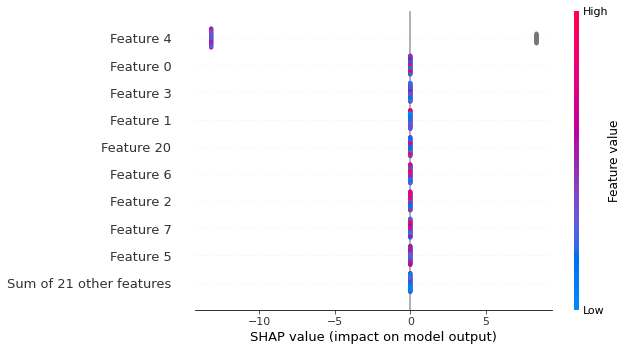

In [94]:
shap.plots.beeswarm(shap.TreeExplainer(lgbm)(X_samp)[:, :, 1])

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
dt = DecisionTreeClassifier()
imputer = SimpleImputer()
dt.fit(imputer.fit_transform(X_train), y_train)
accuracy_score(y_train, dt.predict(imputer.transform(X_train))), accuracy_score(y_test, dt.predict(imputer.transform(X_test)))

(1.0, 0.2982456140350877)

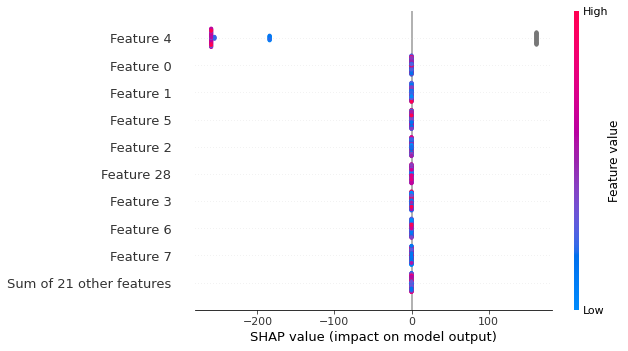

In [92]:
shap.plots.beeswarm(shap.TreeExplainer(lgbm)(X_samp)[:, :, 1])

In [59]:
import shap
def predict_multiple(X):
    return np.array([predict(t, X[i, :]) for i in range(X.shape[0])])
explainer = shap.KernelExplainer(predict_multiple, shap.sample(X_train, 40))

In [61]:
X_samp = shap.sample(X_test, 100)
shap_values = explainer.shap_values(X_samp)

  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:
!pip install --upgrade shap

You should consider upgrading via the 'c:\users\roel\.virtualenvs\diagcovid-ckc2berq\scripts\python.exe -m pip install --upgrade pip' command.


In [38]:
shap_values.shape

(100, 30)

In [42]:
shap.plots.beeswarm(shap_values)

UnboundLocalError: local variable 'values' referenced before assignment

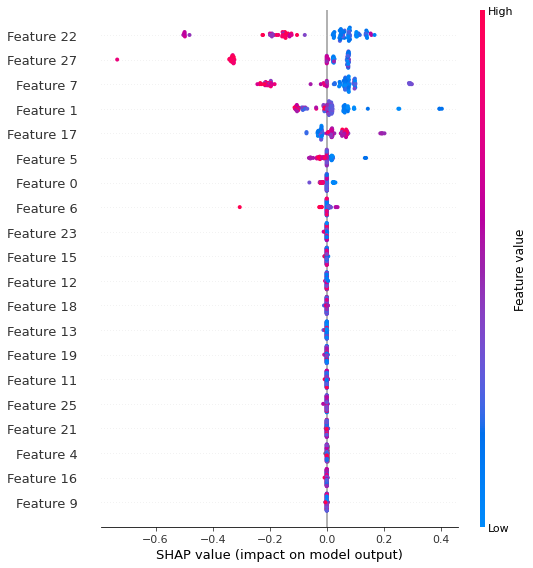

In [62]:
shap.summary_plot(shap_values, features=X_samp)

In [65]:
X_samp[:, 4]

array([0.08682, 0.08928, 0.08182,     nan,     nan, 0.08099, 0.09984,
           nan, 0.0988 , 0.06955, 0.09965, 0.07372, 0.09751, 0.09751,
       0.08261,     nan, 0.1018 ,     nan,     nan, 0.09965, 0.08491,
       0.09751,     nan, 0.07683, 0.08045, 0.09639,     nan, 0.09984,
           nan, 0.09357,     nan, 0.1152 , 0.08928, 0.08182,     nan,
           nan, 0.09751, 0.08582,     nan, 0.08054, 0.08054,     nan,
           nan, 0.1037 , 0.1018 , 0.09984, 0.08983, 0.1037 , 0.09057,
       0.07557, 0.08546, 0.07436, 0.1039 ,     nan,     nan,     nan,
       0.1031 , 0.1031 , 0.06955, 0.06883, 0.09816, 0.09267, 0.09882,
       0.08992, 0.1152 , 0.1078 , 0.09968, 0.1237 ,     nan, 0.09057,
           nan, 0.1018 , 0.08099,     nan, 0.08983, 0.07436,     nan,
           nan, 0.08491,     nan, 0.1225 , 0.1031 ,     nan,     nan,
       0.06883, 0.08261, 0.1237 ,     nan, 0.1039 ,     nan,     nan,
           nan, 0.08928, 0.08421,     nan,     nan,     nan, 0.09882,
       0.07215, 0.12

In [ ]:
shap_values

In [ ]:
gini_impurity(y[y == 0])

In [ ]:
gini_index([y, y[y == 1]])

In [16]:
y[y == 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])